# Test notebook for different batch sizes
### Dataset: Natural Images https://www.kaggle.com/datasets/prasunroy/natural-images
### Test setup: 64 images from the natural images dataset were chosen with 8 images from each class. The model was evaluated for batch sizes from 8 to 256


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
########################################################
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.image import imread
########################################################
import torch
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch.nn.parallel import DataParallel
import torch.multiprocessing as mp
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import torchvision.transforms as transforms
########################################################
import random
import os
from glob import glob
########################################################

In [2]:
!pip install torchvision

In [3]:
pre_path_labels = glob("/kaggle/input/natural-images/natural_images/*")


In [4]:
test_set = []
for pre_path in pre_path_labels:
    img_paths = glob(pre_path + "/*")[:32]
    test_set.extend(img_paths)

In [5]:
len(test_set)

256

In [6]:
class ImagePathDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [7]:
basic_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust the size as needed
    transforms.ToTensor(),
])

test_dataset = ImagePathDataset(test_set, transform=basic_transform)
test_loader = DataLoader(test_dataset, batch_size=64,
                         shuffle=False, num_workers=4)  # look into collate fn

In [8]:
# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bottleneck = nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.bottleneck(x)
        return x


# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(64, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv5 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.relu(self.deconv4(x))
        x = torch.sigmoid(self.deconv5(x))
        return x
# Progressive Image Compression
class ProgressiveAutoEncoder(nn.Module):
    def __init__(self):
        super(ProgressiveAutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        # Encode the input image
        encoded = self.encoder(x)

        # Progressive decoding
        decoded = self.decoder(encoded)
        residual = x - decoded
        return decoded, residual

In [9]:
model_paths = glob("/kaggle/input/convae-tests/pytorch/convae_test/1/*")

In [10]:
model_paths

['/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_decoder_b64.pth',
 '/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_encoder_b16.pth',
 '/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_encoder_b64.pth',
 '/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_decoder_b128.pth',
 '/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_encoder_b256.pth',
 '/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_encoder_b32.pth',
 '/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_encoder_b128.pth',
 '/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_decoder_b32.pth',
 '/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_decoder_b256.pth',
 '/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_decoder_b8.pth',
 '/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_encoder_b8.pth',
 '/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_decoder_b16.pth']

In [11]:
from collections import defaultdict
models_by_batch_size = defaultdict(list
                                  )
from torchvision.utils import make_grid

In [12]:
model_paths.sort()

In [14]:
model_map = [0, 128, 16, 256, 32, 64, 8]

In [15]:
encoders = []
decoders = []
for path in model_paths:
    print(path)
    if 'encoder' in path:
        encoder = Encoder()  # Assuming you have defined the Encoder class
        encoder.load_state_dict(torch.load(path))
        encoder.eval()
        encoders.append(encoder)
    elif 'decoder' in path:
        decoder = Decoder()  # Assuming you have defined the Decoder class
        decoder.load_state_dict(torch.load(path))
        decoder.eval()
        decoders.append(decoder)

/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_decoder_b128.pth
/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_decoder_b16.pth
/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_decoder_b256.pth
/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_decoder_b32.pth
/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_decoder_b64.pth
/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_decoder_b8.pth
/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_encoder_b128.pth
/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_encoder_b16.pth
/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_encoder_b256.pth
/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_encoder_b32.pth
/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_encoder_b64.pth
/kaggle/input/convae-tests/pytorch/convae_test/1/PgIC_encoder_b8.pth


In [16]:
def compress_decompress_image(image, encoder, decoder):
    # Move the image and models to the appropriate device (CPU or GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image = image.to(device)
    encoder = nn.DataParallel(encoder.to(device))
    decoder = nn.DataParallel(decoder.to(device))
    # Compress the image using the encoder
    encoded = encoder(image)
    
    # Decompress the image using the decoder
    decoded = decoder(encoded)
    encoder.module.cpu()
    decoder.module.cpu()

    # Detach the tensors from the computational graph
    for param in encoder.module.parameters():
        param.detach_()

    for param in decoder.module.parameters():
        param.detach_()

    return decoded

In [17]:
import io
from skimage.metrics import structural_similarity as ssim

In [18]:
test_images= next(iter(test_loader))


In [19]:
def plotter(test_images, reconstructed_images, ssim_values, model_name):
    original_grid = make_grid(test_images, nrow=3, normalize=True)
    reconstructed_grid = make_grid(reconstructed_images, nrow=3, normalize=True)

    # Plot the results
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    ax[0].imshow(np.transpose(original_grid.detach().cpu().numpy(), (1, 2, 0)))
    ax[0].set_title('Original Images')
    ax[0].axis('off')

    ax[1].imshow(np.transpose(reconstructed_grid.detach().cpu().numpy(), (1, 2, 0)))
    ax[1].set_title('Reconstructed Images')
    ax[1].axis('off')

    ax[2].bar(range(len(ssim_values)), ssim_values)
    ax[2].set_title(f'SSIM Values for {model_name}')
    ax[2].set_xlabel('Image Index')
    ax[2].set_ylabel('SSIM')

    plt.show()

In [20]:
def avg(ssim_values):
    s = 0
    for i in ssim_values:
        s += i
    return s/len(ssim_values)

Batch ID:128, AVG SSIM: 0.9650776591151953


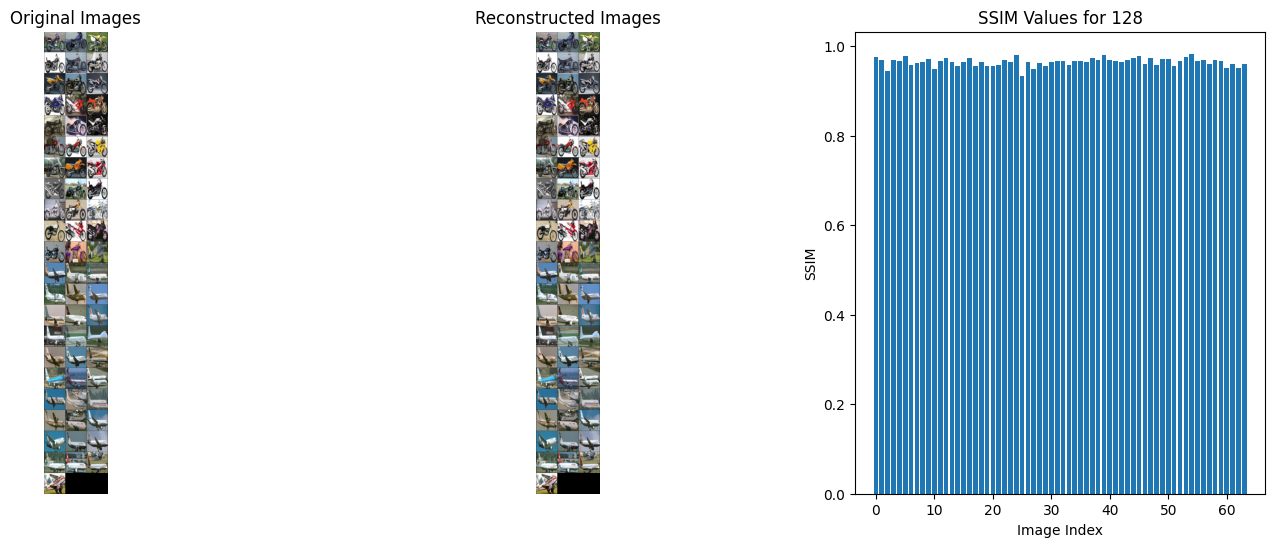

Batch ID:16, AVG SSIM: 0.9748331531882286


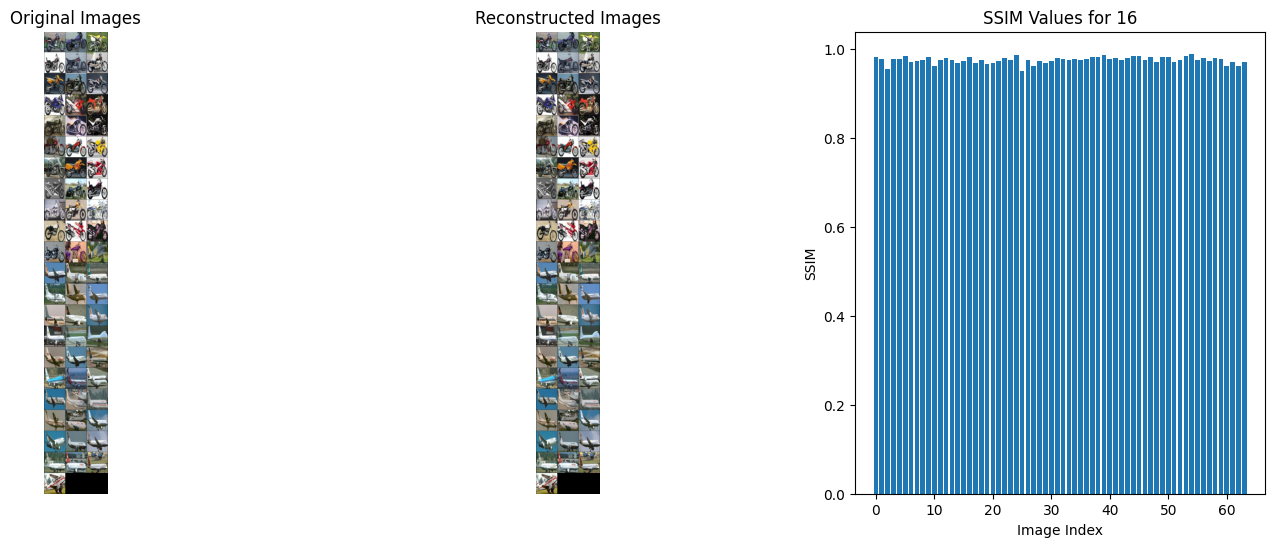

Batch ID:256, AVG SSIM: 0.9294835468754172


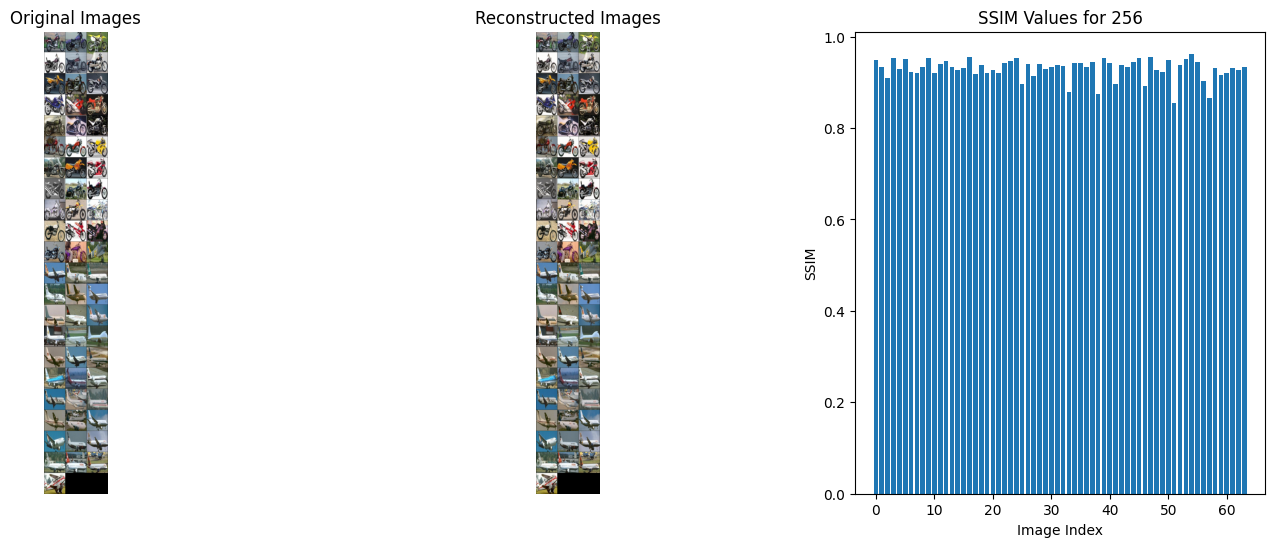

Batch ID:32, AVG SSIM: 0.9753704136237502


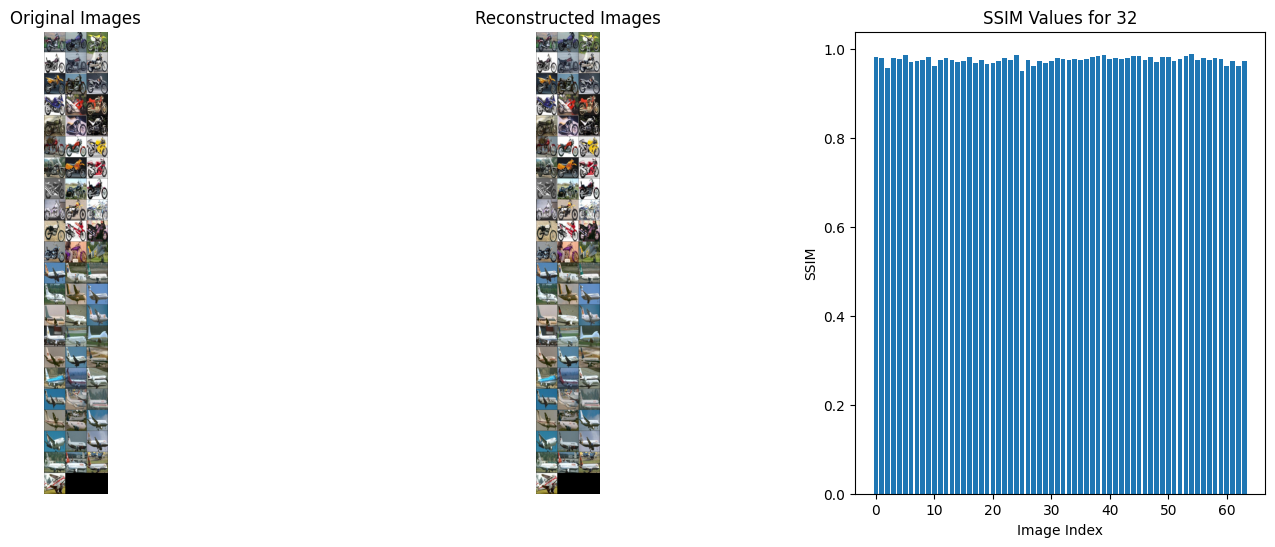

Batch ID:64, AVG SSIM: 0.9708173256367445


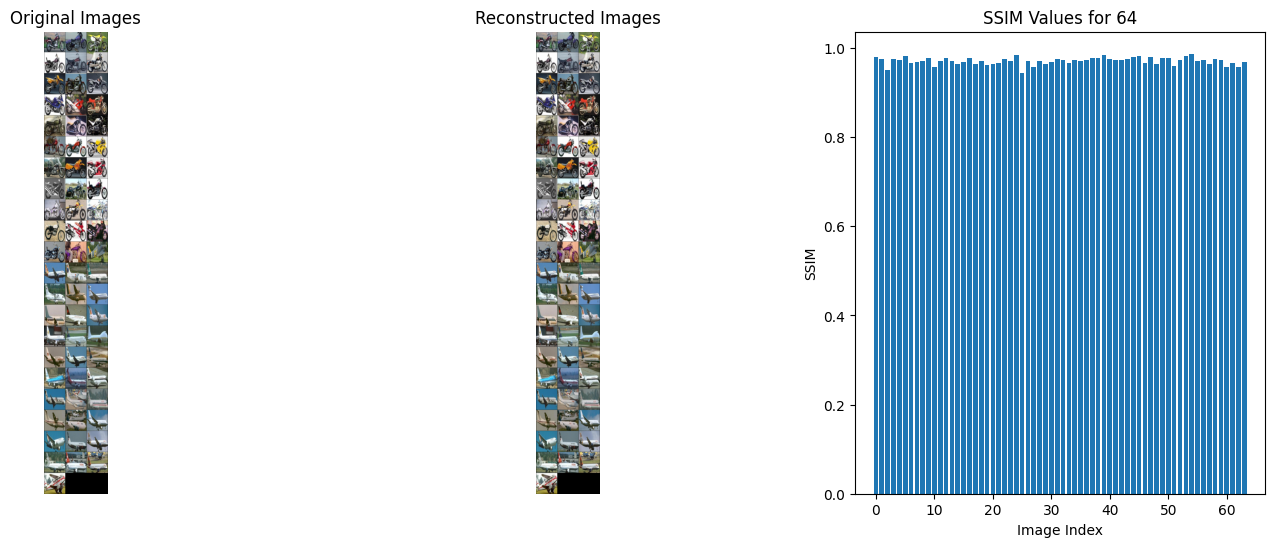

Batch ID:8, AVG SSIM: 0.9756743395701051


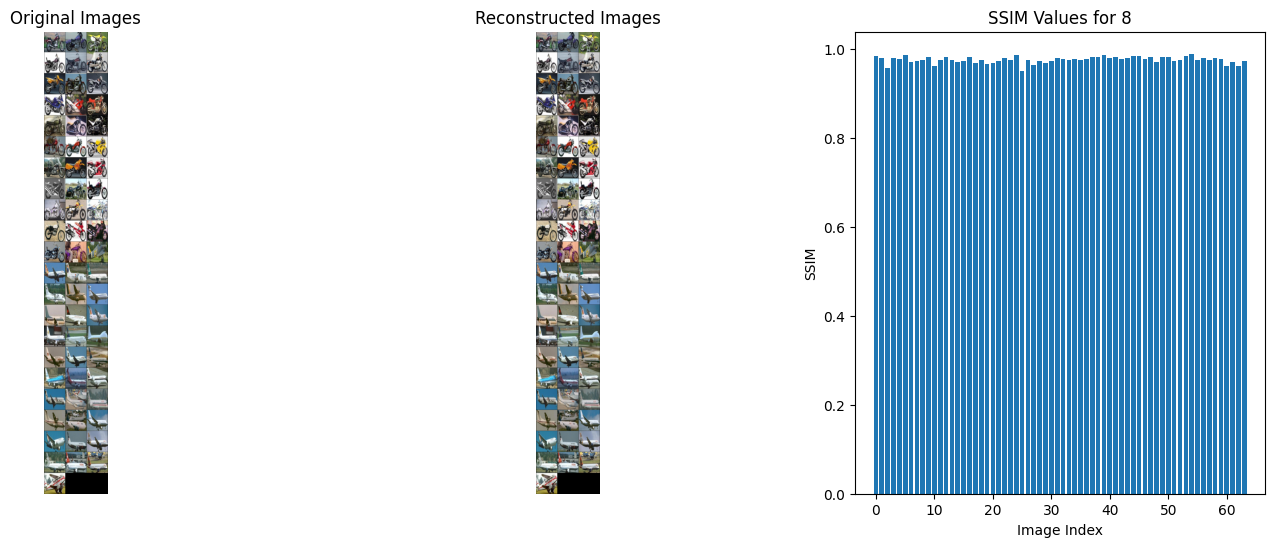

In [21]:
c = 0
for encoder, decoder in zip(encoders, decoders):
    c += 1
    reconstructed_images = compress_decompress_image(test_images, encoder, decoder)
    ssim_values = []

    for orig_img, recon_img in zip(test_images, reconstructed_images):
        orig_img_np = orig_img.permute(1, 2, 0).detach().cpu().numpy()
        recon_img_np = recon_img.permute(1, 2, 0).detach().cpu().numpy()
        ssim_val = ssim(orig_img_np, recon_img_np, data_range=1.0, multichannel=True, channel_axis=2)
        ssim_values.append(ssim_val)

    print(f"Batch ID:{model_map[c]}, AVG SSIM: {sum(ssim_values) / len(ssim_values)}")

    plotter(test_images, reconstructed_images, ssim_values, model_map[c])   

In [22]:
!nvidia-smi

Wed May  8 04:23:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0              26W /  70W |   2413MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [23]:
import gc
gc.collect()
torch.cuda.empty_cache()